# Random forest and XGBoost regressors

In [172]:
from pathlib import Path
import warnings
import time
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [29]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
# Seems XGBoost ignores the filter and my attempts to suppress its FutureWarnings!
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=Warning, module='xgboost')
# warnings.filterwarnings('ignore')

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [4]:
# Paths to my repo's data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [123]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
# Not necessary when using XGBoost though (try both!)
df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

# df.info()

#### Separate ERA5 and ERA5-derived features into two dataframes for model training, tuning, and evaluation
- And to allow for quicker selections during experimention

In [124]:
# My 9 weighted ERA5 features
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# My 9 unweighted ERA5 features
unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes including each group
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

-----

## Random forest regressor to establish a baseline RMSE
- This is just to set a baseline RMSE score that I can improve upon using more advanced techniques
- I've chosen the start of 2023 at my split point
    - That means c. 90% train data and c. 10% test data

#### Plot the train and test split to better visualise the split

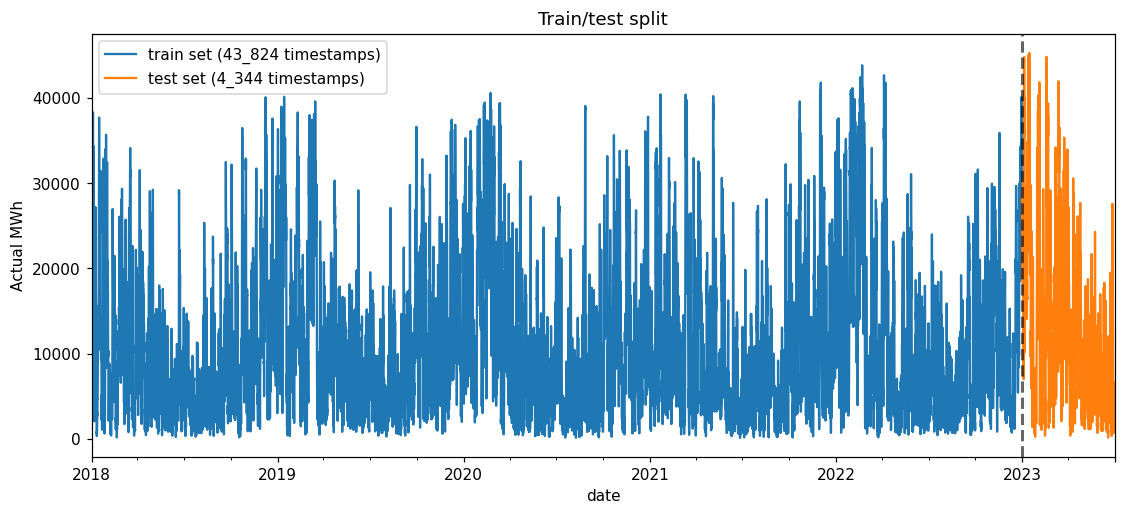

In [125]:
split_date = '2023-01-01'

# Separate train and test sets on chosen date
train_set = df.loc[df.index < split_date]
test_set = df.loc[df.index >= split_date]

# Plot the split
fig, ax = plt.subplots(figsize=(12,5))

train_set['actual_generated_smard_mwh'].plot(ax=ax, label='training set', title='Train/test split')
test_set['actual_generated_smard_mwh'].plot(ax=ax, label='test set')

ax.axvline('2023-01-01', color='black', ls='--', linewidth=2, alpha=0.6)
ax.legend(['train set (43_824 timestamps)', 'test set (4_344 timestamps)'])
ax.set_xlabel('date')
ax.set_ylabel('Actual MWh')

plt.show()

#### Function that assigns X & y and creates a pipeline with a column transformer and random forest regressor as steps

In [126]:
def create_pipeline_and_sets_using_df(df, split_date='2023-01-01'):
    """
    Input is either the unweighted or weighted dataframe
    Output is the pipeline object and X & y train-test sets
    """
    # Separate train and test sets on chosen date
    train_set = df.loc[df.index < split_date].copy()
    test_set = df.loc[df.index >= split_date].copy()

    # Assign my train sets
    X_train = train_set.drop(columns=['actual_generated_smard_mwh'])
    y_train = train_set['actual_generated_smard_mwh']

    # Assign my test sets
    X_test = test_set.drop(columns=['actual_generated_smard_mwh'])
    y_test = test_set['actual_generated_smard_mwh']

    # List of categorical features for ordinal encoding
    # Get from df as column names depend on if using weighted or unweighted df
    categorical_features = df.select_dtypes('category').columns.to_list()

    # the unique values for each categorical feature; must be in order of list above
    categories = [
        # meteorological_season
        ['winter', 'spring', 'summer', 'autumn'],
        # wind_direction_intercardinal_10m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
        # wind_direction_intercardinal_100m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    ]

    # Instantiate ordinal encoder and provide unique categories (could also use defaul of auto)
    ordinal_encoder = OrdinalEncoder(categories=categories)
    
    # Features to one-hot encode
    one_hot_features = ['meteorological_season']
    one_hot_features.extend(df.filter(regex='inter', axis=1).columns.to_list())
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Create pipeline object with named steps
    rf_pipeline = Pipeline([
        # Step 1: run categorical features through ordinal encoder
        ('transformer',
            ColumnTransformer(
            transformers=[
                ('categorical', ordinal_encoder, categorical_features),
                # ('one_hot', one_hot_encoder, one_hot_features), 
            ],
            remainder='passthrough',
            verbose_feature_names_out=False,
        )),
        # Step 2: instantiate random forest regressor
        ('model', RandomForestRegressor(
            n_estimators=100,
            max_depth=8,
            verbose=0,
            n_jobs=-1,
        )),
    ], verbose=2).set_output(transform='pandas')
    
    return rf_pipeline, X_train, y_train, X_test, y_test

#### Create function to fit and score the random forest pipeline/model

In [140]:
def fit_and_score_model(pipeline, X_train, y_train, X_test, y_test):
    # fit model to the train data (via pipeline object)
    pipeline.fit(X_train, y_train)
    # make target predictions using test set
    y_preds = pipeline.predict(X_test)
    # calculate mean RMSE of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'Mean RMSE of model predictions: {rmse:.2f} MWh')
    # return pipeline with fitted model inside
    return y_preds, rmse

#### Run the function and get RMSE score of test set for both `df_unweighted` and `df_weighted`

##### RMSE score using `df_unweighted`

In [141]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_unweighted)
# Fit and score my model
rf_unweighted_preds, rf_unweighted_rmse = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.5s
Mean RMSE of model predictions: 2305.65 MWh


##### RMSE score using `df_weighted`

In [142]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_weighted)
# Fit and score my model
rf_weighted_preds, rf_weighted_rmse = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.7s
Mean RMSE of model predictions: 2004.64 MWh


### Best mean RMSE using an 'out of the box' random forest is around 2,000 MWh. And unsurprisingly this was achieved using the ERA5 weighted features

----

-----

## Gradient boosted tree regressor using XGBoost
- Here I will use three sets:
    - train
    - validation
    - hold-out test set
- Go with a rolling window approach using TimeSeriesSplit to cap computational cost of cross-validation
- Documentation on `XGBRegressor` here: https://xgboost.readthedocs.io/en/stable/python/python_api.html

#### Set aside a hold-out test sets for `df_weighted` and `df_unweighted`
- Everything after 2023-01-01 (so I can compare with random forest baseline RMSE score)
    - 'Out of the box' random forest RMSE scores on 2023 test set:
        - `df_unweighted` = 2300
        - `df_weighted` = 2000

In [347]:
# All timestamps after this date are reserved for the 'unseen', hold-out test set!
split_date = '2023-01-01'

# Hold-out sets; the unseen data that I'll use to make predictions using the pre-final and final models
df_hold_out_test_set_weighted = df_weighted.loc[df_weighted.index >= split_date].copy()
df_hold_out_test_set_unweighted = df_unweighted.loc[df_unweighted.index >= split_date].copy()

# Remove my hold-out set from the dataframes
df_weighted = df_weighted.loc[df_weighted.index < split_date].copy()
df_unweighted = df_unweighted.loc[df_unweighted.index < split_date].copy()

#### Set the number of time series splits

In [348]:
n_splits = 5

#### Visualise time series split I want to employ

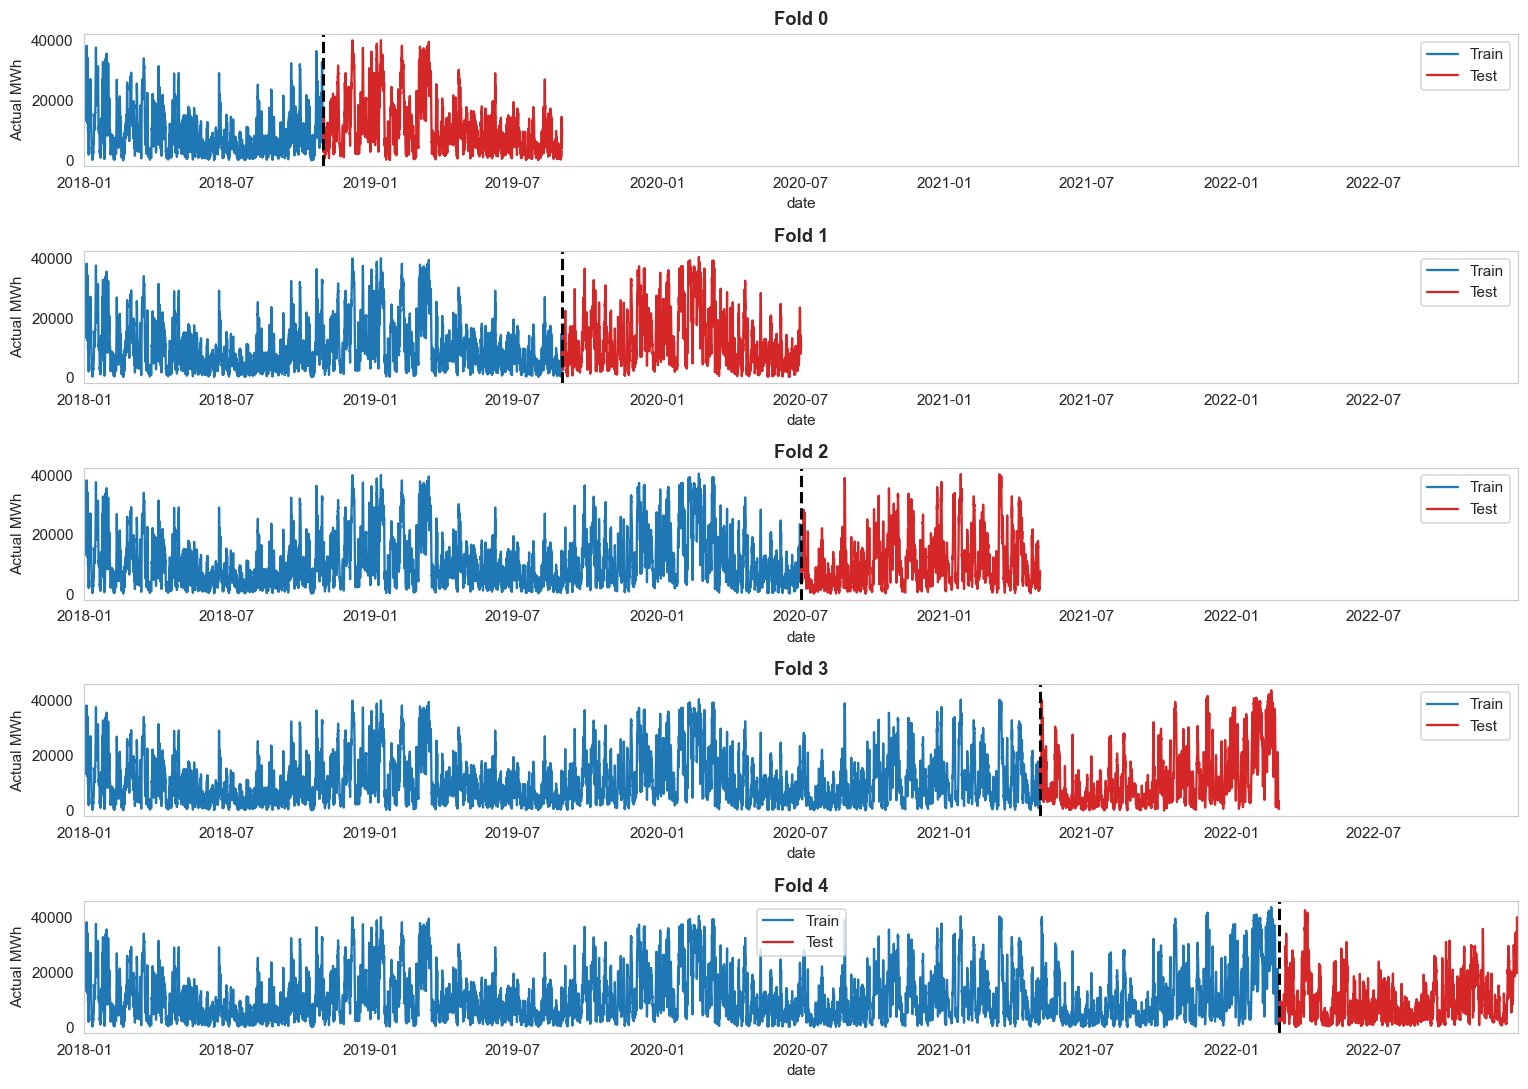

In [349]:
def plot_time_series_split(df, n_splits=n_splits):
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        # gap=48,
        # Around 1 year and 2 months for each training split
        # max_train_size=10_000,
        # test_size=1_000,
    )

    # Plot the splits
    fig, axes = plt.subplots(n_splits, figsize=(14, 10))

    # Loop through the splits and plot
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]
        
        # plot the target variable (actual power generated)
        ax.plot(y.index[train_index], y.iloc[train_index], 'tab:blue', label='Train')
        ax.plot(y.index[test_index], y.iloc[test_index], 'tab:red', label='Test')
        # set x axis limits
        ax.set_xlim(X.index.min(), X.index.max())
        # plot vertical line denoting where the split takes place
        ax.axvline(
            y.index[train_index][-1], color='black', linestyle='--', linewidth=2, alpha=1
        )

        ax.legend()
        ax.set_title(f'Fold {i}', fontweight='bold')
        ax.set_xlabel('date')
        ax.set_ylabel('Actual MWh')
        ax.grid(False)

    plt.tight_layout()
    plt.show()

# Execute the function and plot the time series splits
plot_time_series_split(df_unweighted)

-----

## Next steps:
- Step 1: Use TimeSeriesSplit and GridSearchCV to find best model hyperparameters using RMSE as scoring metric
    - Score hold-out test set using this pre-final model
- Step 2: Use best model params to train final model using early stopping to prevent overfitting
    - Score hold-out test set using final model
- Step 3: Plot predictions against actuals and show final RMSE

----

### Step 1
#### Use TimeSeriesSplit and GridSearchCV to find best model hyperparameters using RMSE as scoring metric
- Even a modest param grid with 5 time series splits was pushing 70k fits!
- Switching to RandomizedSearchCV instead

In [58]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [59]:
def find_best_parameters(df, n_splits=n_splits):
    """
    Input is either the unweighted or weighted dataframe (up to end of 2022)
    Output is the fitted GridSearchCV object containing the best model params and other attributes
    """
    # Assign X & y using df; keep datetime as index and select indexes using .iloc
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split object
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        # gap=48,
        # Around 1 year and 2 months for each training split
        # max_train_size=10_000,
        # test_size=1_000,
    )
    
    # Default objective is 'reg:squarederror'
    xgbr = xgb.XGBRegressor(
        # this method is recommended for datasets around 40k+ instances
        tree_method='hist',
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        verbosity=0,
    )
    
    # Parameters to include in GridSearchCV
    # The below required almost 70k fits!
    # param_grid = {
    #     'n_estimators': [50, 100, 200, 500],
    #     'learning_rate': [0.05, 0.1, 0.2, 0.3],
    #     'max_depth': [3, 4, 5, 6, 7, 8],
    #     'min_child_weight': [1, 5, 10],
    #     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    #     'subsample': [0.7, 0.9],
    #     'gamma': [0, 0.1, 0.2],
    #     'lambda': [0.1, 1],
    # }
    
    # Grid search my params with time series cross-validation
    # grid_search = GridSearchCV(
    #     estimator=xgbr,
    #     param_grid=param_grid,
    #     scoring='neg_root_mean_squared_error',
    #     cv=tscv,
    #     verbose=1,
    #     n_jobs=-1
    # )
    # grid_search.fit(X, y)
    
    # A more extensive param grid for randomised search
    param_grid = {
        # boosted trees/rounds
        'n_estimators': [50, 100, 200, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        # max number of bins per feature (since I'm using a histogram tree method); 256 is the default?
        'max_bin': [128, 256, 512, 1024],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bynode': [0.6, 0.7, 0.8, 0.9, 1.0],
        
        # ----- regularisation params to help prevent overfitting ------- 
        # L1 regularisation on weights
        'reg_alpha': [0.1, 1, 2, 5],
        # L2 regularisation on weights
        'reg_lambda': [0.1, 1, 2, 5],
        # regularisation on tree splits (0 = no regularisation)
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    }
    
    # Random search my params with time series cross-validation
    random_search = RandomizedSearchCV(
        estimator=xgbr,
        param_distributions=param_grid,
        # num of param combinations to sample from grid
        n_iter=100,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1,
        random_state=10,
    )

    random_search.fit(X, y)
      
    return random_search

In [60]:
# start timer
start_time = time.time()

# execute my custom random search function for both dataframes
random_search_unweighted = find_best_parameters(df_unweighted)
random_search_weighted = find_best_parameters(df_weighted)

# end timer
end_time = time.time()

print('')
print('---- Done! ---- ')
print(f"Time taken to find best parameters performing {len(random_search_unweighted.cv_results_['mean_fit_time']) * n_splits} fits each: {end_time - start_time:.2f} seconds")
print('----------')
print(f'Best parameters found for df_unweighted: {random_search_unweighted.best_params_}')
print(f'Lowest mean RMSE found for for df_unweighted: {-random_search_unweighted.best_score_}')
print('----------')
print(f'Best parameters found for df_weighted: {random_search_weighted.best_params_}')
print(f'Lowest mean RMSE found for df_weighted: {-random_search_weighted.best_score_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



---- Done! ---- 
Time taken to find best parameters performing 500 fits each: 819.83 seconds
----------
Best parameters found for df_unweighted: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 6, 'max_bin': 256, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}
Lowest mean RMSE found for for df_unweighted: 1437.4572012317105
----------
Best parameters found for df_weighted: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 6, 'max_bin': 256, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}
Lowest mean RMSE found for df_weighted: 1386.6733642832996


In [61]:
print(-random_search_unweighted.best_score_)
print(-random_search_weighted.best_score_)

1437.4572012317105
1386.6733642832996


In [62]:
print(random_search_unweighted.best_index_)
print(random_search_weighted.best_index_)

78
78


In [63]:
print(random_search_unweighted.best_params_)
print('-----')
print(random_search_weighted.best_params_)

{'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 6, 'max_bin': 256, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}
-----
{'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 6, 'max_bin': 256, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}


#### Read results into pandas dataframe for easier inspection
- Quick inspection to verify that all time splits have been scored!

In [64]:
df_cv_results_unweighted = pd.DataFrame(random_search_unweighted.cv_results_)
df_cv_results_weighted = pd.DataFrame(random_search_weighted.cv_results_)

df_cv_results = df_cv_results_unweighted.merge(
    df_cv_results_weighted,
    how='inner',
    left_index=True, 
    right_index=True, 
    suffixes=(None, '_weighted')
)
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mean_fit_time                     100 non-null    float64
 1   std_fit_time                      100 non-null    float64
 2   mean_score_time                   100 non-null    float64
 3   std_score_time                    100 non-null    float64
 4   param_subsample                   100 non-null    object 
 5   param_reg_lambda                  100 non-null    object 
 6   param_reg_alpha                   100 non-null    object 
 7   param_n_estimators                100 non-null    object 
 8   param_min_child_weight            100 non-null    object 
 9   param_max_depth                   100 non-null    object 
 10  param_max_bin                     100 non-null    object 
 11  param_learning_rate               100 non-null    object 
 12  param_gam

In [65]:
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,param_max_bin,param_learning_rate,param_gamma,param_colsample_bytree,param_colsample_bynode,param_colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time_weighted,std_fit_time_weighted,mean_score_time_weighted,std_score_time_weighted,param_subsample_weighted,param_reg_lambda_weighted,param_reg_alpha_weighted,param_n_estimators_weighted,param_min_child_weight_weighted,param_max_depth_weighted,param_max_bin_weighted,param_learning_rate_weighted,param_gamma_weighted,param_colsample_bytree_weighted,param_colsample_bynode_weighted,param_colsample_bylevel_weighted,params_weighted,split0_test_score_weighted,split1_test_score_weighted,split2_test_score_weighted,split3_test_score_weighted,split4_test_score_weighted,mean_test_score_weighted,std_test_score_weighted,rank_test_score_weighted
0,15.037600,3.646818,0.381390,0.007844,0.6,1,1,500,5,8,512,0.1,0.2,1.0,0.6,0.9,"{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...",-1661.946038,-1571.542409,-1486.399680,-1566.470645,-1377.501922,-1532.772139,95.481793,11,20.295648,5.064770,0.516052,0.014067,0.6,1,1,500,5,8,512,0.1,0.2,1.0,0.6,0.9,"{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...",-1511.527056,-1769.994707,-1358.518340,-1396.902456,-1348.705589,-1477.129630,157.448981,15
1,0.677308,0.236409,0.042778,0.002824,0.8,2,2,100,1,5,128,0.4,0.1,0.8,0.6,0.9,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",-2092.385439,-1783.070811,-2034.454687,-1996.308180,-1550.138654,-1891.271554,200.029974,69,0.920120,0.249782,0.059518,0.004066,0.8,2,2,100,1,5,128,0.4,0.1,0.8,0.6,0.9,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",-1694.122439,-1680.160144,-1766.375604,-1729.880491,-1802.918184,-1734.691372,45.390365,68
2,2.449671,0.875745,0.149662,0.007998,0.8,2,1,500,1,4,256,0.05,0.1,0.8,0.7,0.7,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",-1667.273134,-1720.639904,-1520.805727,-1691.993187,-1421.219821,-1604.386355,114.612645,21,3.372314,1.146179,0.196658,0.024025,0.8,2,1,500,1,4,256,0.05,0.1,0.8,0.7,0.7,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",-1522.570678,-1604.323523,-1369.338017,-1575.566382,-1369.260079,-1488.211736,100.572139,18
3,1.248692,0.349952,0.043673,0.002753,0.9,2,1,100,10,5,1024,0.3,0.2,0.6,1.0,0.6,"{'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha...",-1834.884009,-1918.998982,-1734.951696,-1803.845684,-1539.253330,-1766.386740,128.033818,53,1.703324,0.507201,0.055748,0.003534,0.9,2,1,100,10,5,1024,0.3,0.2,0.6,1.0,0.6,"{'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha...",-1671.378013,-1968.374957,-1467.877038,-1793.106519,-1461.559142,-1672.459134,194.142100,63
4,7.585108,2.127639,0.470986,0.012897,1.0,0.1,2,1000,10,6,128,0.4,0.1,0.8,1.0,0.8,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",-1697.290514,-1701.385366,-1660.569577,-1705.556261,-1507.113730,-1654.383089,75.359792,30,10.589795,2.703048,0.645652,0.033937,1.0,0.1,2,1000,10,6,128,0.4,0.1,0.8,1.0,0.8,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",-1645.837730,-1562.246095,-1558.575596,-1632.685401,-1530.572175,-1585.983399,45.052567,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13.564904,3.567339,0.242398,0.035357,1.0,0.1,2,200,5,9,512,0.1,0.4,0.9,1.0,0.6,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",-1757.450925,-1659.503245,-1489.246387,-1656.193942,-1421.607640,-1596.800428,122.905004,19,15.125978,3.396685,0.257376,0.046841,1.0,0.1,2,200,5,9,512,0.1,0.4,0.9,1.0,0.6,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",-1576.968724,-1646.888097,-1330.456862,-1448.886854,-1368.564721,-1474.353051,120.701392,14
96,5.257650,1.237202,0.061847,0.007104,0.9,5,1,5

### Make predictions and score hold-out test set
- Intermediate check to see if early stopping can improve on this RMSE score!
- Best random forest RMSE on weighted was 2000. A score of 1500 is around a 25% decrease in error!

In [145]:
def score_hold_out(estimator, df):
    """
    Input df is the hold-out test set
    Output is an array of predictions for plotting
    """
    X_test = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y_test = df['actual_generated_smard_mwh'].copy()

    # make target predictions using test set
    y_preds = estimator.predict(X_test)
    # calculate mean RMSE of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'Mean RMSE of model predictions on hold-out set: {rmse:.2f} MWh')
    return y_preds, rmse

#### Score pre-final models created through random search

In [146]:
random_search_unweighted_preds, random_search_unweighted_rmse = score_hold_out(random_search_unweighted.best_estimator_, df_hold_out_test_set_unweighted)

Mean RMSE of model predictions on hold-out set: 1637.45 MWh


In [147]:
random_search_weighted_preds, random_search_weighted_rmse = score_hold_out(random_search_weighted.best_estimator_, df_hold_out_test_set_weighted)

Mean RMSE of model predictions on hold-out set: 1549.35 MWh


In [87]:
random_search_weighted.best_params_

{'subsample': 0.6,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 1000,
 'min_child_weight': 10,
 'max_depth': 6,
 'max_bin': 256,
 'learning_rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.8,
 'colsample_bylevel': 0.9}

-----

### Step 2
#### Now use best params to train final model all data up to 2023 using early stopping to prevent overfitting

In [104]:
def train_final_model_early_stopping(df, random_search):
    """
    Input is either the weighted or unweighted dataframe (up to end of 2022)
    and the fitted GridSearchCV object
    Output is the fitted XGB model using best model params and early stopping
    """
    # Split using c. 80% of timestamps for train set and the rest for test (round to nearest thousand)
    train_length = int(round(len(df) * 0.8, -3))
    test_length = len(df) - train_length

    # Train sets for X & y - used to fit new model using best params from GridSearchCV
    X_train = df.iloc[:train_length].drop(columns=['actual_generated_smard_mwh']).copy()
    y_train = df.iloc[:train_length]['actual_generated_smard_mwh'].copy()

    # Validation sets for X & y
    # Validation length around one full year (all of 2022)
    X_val = df.iloc[-test_length:].drop(columns=['actual_generated_smard_mwh']).copy()
    y_val = df.iloc[-test_length:]['actual_generated_smard_mwh'].copy()

    # Use best model parameters from GridSearchCV
    best_params = random_search.best_params_
    xgbr_final = xgb.XGBRegressor(
        tree_method='hist',
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        # Stop if no RMSE improvement in eval set after a number of trees/rounds
        early_stopping_rounds=60,
        **best_params,
    )

    # Evaluate train and validation sets to score and trigger early stopping and prevent overfitting
    # Early stopping triggered by validation set (validation_1) 
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgbr_final.fit(
        X_train,
        y_train, 
        # eval_metric='rmse',
        eval_set=eval_set,
        verbose=True,
    )
    return xgbr_final

#### Note how RMSE on train set continue to improve while validation set gets worse
- Hence why early stopping helps to prevent overfitting!

##### Using *unweighted* ERA5 features

In [105]:
xgbr_final_unweighted = train_final_model_early_stopping(df_unweighted, random_search_unweighted)

[0]	validation_0-rmse:13205.10690	validation_1-rmse:14350.54136
[1]	validation_0-rmse:12562.67264	validation_1-rmse:13692.34832
[2]	validation_0-rmse:11954.21923	validation_1-rmse:13069.39336
[3]	validation_0-rmse:11375.34418	validation_1-rmse:12473.88228
[4]	validation_0-rmse:10825.38374	validation_1-rmse:11907.62810
[5]	validation_0-rmse:10302.55230	validation_1-rmse:11367.11140
[6]	validation_0-rmse:9806.64025	validation_1-rmse:10859.32305
[7]	validation_0-rmse:9336.52132	validation_1-rmse:10374.23000
[8]	validation_0-rmse:8890.59723	validation_1-rmse:9912.14952
[9]	validation_0-rmse:8474.54292	validation_1-rmse:9490.60793
[10]	validation_0-rmse:8073.36147	validation_1-rmse:9075.60627
[11]	validation_0-rmse:7692.41885	validation_1-rmse:8683.65242
[12]	validation_0-rmse:7331.73323	validation_1-rmse:8309.57550
[13]	validation_0-rmse:6988.85249	validation_1-rmse:7949.32279
[14]	validation_0-rmse:6663.47665	validation_1-rmse:7610.06064
[15]	validation_0-rmse:6355.56642	validation_1-rmse

In [106]:
print(xgbr_final_unweighted.best_iteration)
print(xgbr_final_unweighted.best_score)

911
1438.028801190886


##### Using *weighted* ERA5 features --> should see a better RMSE

In [107]:
xgbr_final_weighted = train_final_model_early_stopping(df_weighted, random_search_weighted)

[0]	validation_0-rmse:13204.54228	validation_1-rmse:14356.08243
[1]	validation_0-rmse:12556.59030	validation_1-rmse:13691.28054
[2]	validation_0-rmse:11941.99202	validation_1-rmse:13060.88341
[3]	validation_0-rmse:11357.35613	validation_1-rmse:12463.35997
[4]	validation_0-rmse:10803.23089	validation_1-rmse:11899.67938
[5]	validation_0-rmse:10276.42884	validation_1-rmse:11359.91370
[6]	validation_0-rmse:9776.88111	validation_1-rmse:10849.54503
[7]	validation_0-rmse:9301.42297	validation_1-rmse:10361.61407
[8]	validation_0-rmse:8850.68325	validation_1-rmse:9897.89431
[9]	validation_0-rmse:8422.56259	validation_1-rmse:9459.73452
[10]	validation_0-rmse:8017.24351	validation_1-rmse:9044.10223
[11]	validation_0-rmse:7642.20070	validation_1-rmse:8663.70910
[12]	validation_0-rmse:7276.08486	validation_1-rmse:8286.51173
[13]	validation_0-rmse:6928.80004	validation_1-rmse:7927.98290
[14]	validation_0-rmse:6599.13488	validation_1-rmse:7585.87910
[15]	validation_0-rmse:6287.25899	validation_1-rmse

#### Best boosting round and its RMSE score (triggered by early stopping)

In [108]:
print(xgbr_final_weighted.best_iteration)
print(xgbr_final_weighted.best_score)

745
1387.6269722691438


##### Use final model to make predictions for the first half of 2023 using the hold-out test set 
- I have not used this hold-out set yet, thereby simulating 'unseen' data 
- Did early stopping improve the RMSE?

#### Final model RMSE on hold-out set

In [149]:
xgbr_final_unweighted_preds, xgbr_final_unweighted_rmse = score_hold_out(xgbr_final_unweighted, df_hold_out_test_set_unweighted)

Mean RMSE of model predictions on hold-out set: 1779.60 MWh


In [151]:
xgbr_final_weighted_preds, xgbr_final_weighted_rmse = score_hold_out(xgbr_final_weighted, df_hold_out_test_set_weighted)

Mean RMSE of model predictions on hold-out set: 1679.50 MWh


#### Best scores seen so far:
- Early stopping: ~1559~ ~1504~ ~1471~ 1378
- **Hold-out test set: ~1843~ ~1787~ ~1776~ ~1729~ 1650**

- Best params so far:

```
{'subsample': 0.8,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 8,
 'max_bin': 512,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 1.0}
```

----

### Step 3
#### Plot predictions against actuals and show final RMSE
- Plot RF weighted, 

In [234]:
# create dict of all relevant model RMSE scores
rmse_scores_dict = {
    'Random forest - unweighted': rf_unweighted_rmse,
    'Random forest - weighted': rf_weighted_rmse,
    'XGBR unweighted random search': random_search_unweighted_rmse,
    'XGBR weighted random search': random_search_weighted_rmse,
    'XGBR unweighted early stopping': xgbr_final_unweighted_rmse,
    'XGBR weighted early stopping': xgbr_final_weighted_rmse,
}

In [333]:
df_scores['model_type'] = df_scores['labels'].str.contains(r'forest', case=False, na=False).map(
    {True: 'random forest regressor', False: 'gradient boosted regressor'})


0       random forest regressor
1       random forest regressor
2    gradient boosted regressor
3    gradient boosted regressor
4    gradient boosted regressor
5    gradient boosted regressor
Name: labels, dtype: object

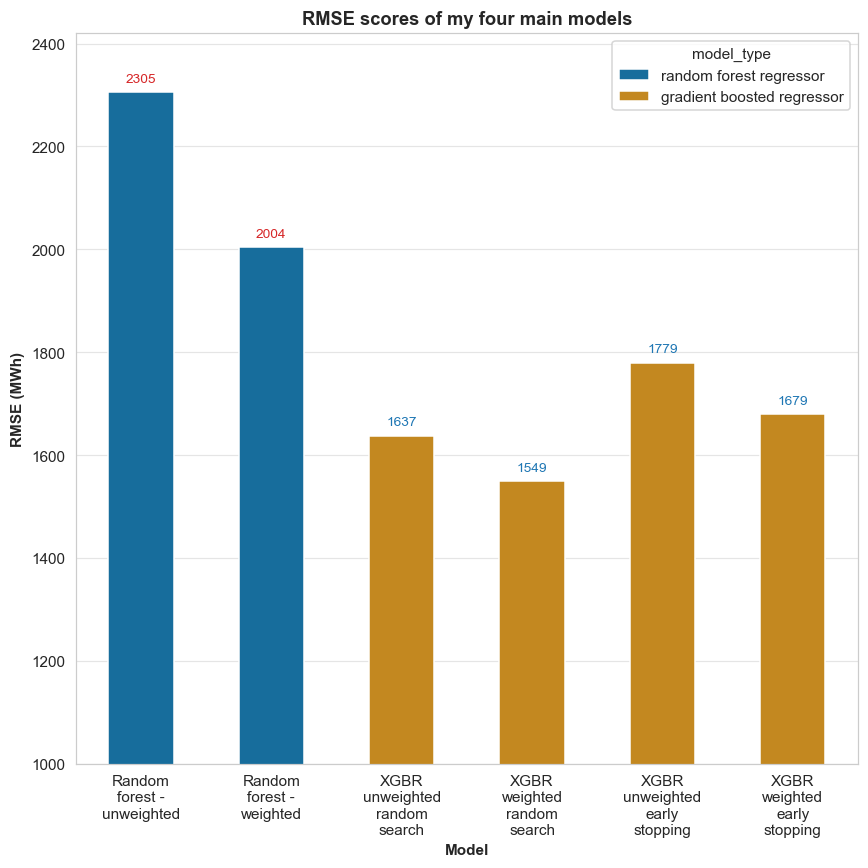

In [363]:
# use dict of scores to create dataframe
df_scores = pd.DataFrame(list(rmse_scores_dict.items()), columns=['labels', 'values'])

# cast values to int
df_scores['values'] = df_scores['values'].astype('int')

# create a new column of model type for plotting
df_scores['model_type'] = df_scores['labels'].str.contains(r'forest', case=False, na=False).map(
    {True: 'random forest regressor', False: 'gradient boosted regressor'})

# wrap label text and insert into new column
df_scores['labels_wrapped'] = df_scores['labels'].apply(lambda x: textwrap.fill(x, 10))

# create plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    x='labels_wrapped',
    y='values', 
    data=df_scores,
    hue='model_type',
    palette='colorblind',
    # color='tab:blue',
    width=0.5,
    dodge=False,
)

# adjust axes objects
ax.set_title('RMSE scores of my four main models', fontweight='bold')
ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('RMSE (MWh)', fontweight='bold')
ax.set_axisbelow(True)
ax.grid(color='grey', linestyle='-', axis='y', alpha=0.2)

# bar labels for random forest group
ax.bar_label(
    ax.containers[0],
    labels=df_scores['values'], 
    padding=5,
    fontsize=9,
    color='tab:red',
    fmt='%.2f',
)

# bar labels for gradient boosted group
ax.bar_label(
    ax.containers[1],
    labels=df_scores['values'], 
    padding=5,
    fontsize=9,
    color='tab:blue',
    fmt='%.2f',
)

ax.set_ylim(bottom=1000)

plt.tight_layout()
plt.show()

In [194]:
df.loc[df.index >= '2023-01-01'].loc[:, 'actual_generated_smard_mwh'].describe()

count     4344.000000
mean     13106.810543
std      10129.088143
min        145.500000
25%       5228.000000
50%      10298.875000
75%      18324.937500
max      45285.250000
Name: actual_generated_smard_mwh, dtype: float64

### Plot the line plots of predictions vs actuals
- `rf_weighted_preds`
- `xgbr_final_weighted_preds`
- actuals

#### Create a dataframe of the two model predictions and the true target values (aka actuals)

In [324]:
# select just the actual hourly power generated
actuals = df.loc[df.index >= '2023-01-01'].loc[:, 'actual_generated_smard_mwh'].copy()

# check that all lengths are true and that I didn't mess up somewhere
print(len(rf_weighted_preds) == len(xgbr_final_weighted_preds) == len(actuals)) == len(random_search_weighted_preds)

# create dataframe of preds vs actuals
df_preds_vs_actuals = actuals.to_frame(name='smard_actuals')

# add array of preds to dataframe
df_preds_vs_actuals['rfr_unweighted'] = rf_unweighted_preds
df_preds_vs_actuals['xgbr_weighted'] = random_search_weighted_preds

df_preds_vs_actuals

True


,smard_actuals,rfr_unweighted,xgbr_weighted
datetime_utc,,,
2023-01-01 00:00:00+00:00,29305.00,32324.177810,29867.765625
2023-01-01 01:00:00+00:00,29266.00,32404.762988,29710.384766
2023-01-01 02:00:00+00:00,27008.50,27822.006726,29041.580078
2023-01-01 03:00:00+00:00,26438.75,27248.938273,28794.869141
2023-01-01 04:00:00+00:00,26795.00,26489.124813,28777.400391
...,...,...,...
2023-06-30 19:00:00+00:00,1698.75,2575.622352,2453.783203
2023-06-30 20:00:00+00:00,2334.25,2443.255570,2737.491699
2023-06-30 21:00:00+00:00,3734.00,2726.223248,4119.798340


#### Function to plot lines between two dates for better inspection

In [325]:
def plot_actuals_vs_preds(df, start_date, end_date):
    # set theme
    sns.set_style('whitegrid')

    # instantiate plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # plot data
    sns.lineplot(
        data=df.loc[start_date: end_date],
        # Set1 also looks nice
        palette='colorblind',
        ax=ax
    )

    # adjust axes objects
    ax.set_title('Model predictions vs actuals', fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Hourly power generated (MWh)', fontweight='bold')
    ax.grid(color='gray', linestyle='-', axis='both', alpha=0.3, linewidth=0.5)


    # add a legend
    ax.legend(title='Data', loc='upper right')

    plt.tight_layout()
    plt.show()

#### Plot lines choosing start and end dates (must be within first half of 2023!)

#### Plotting one day

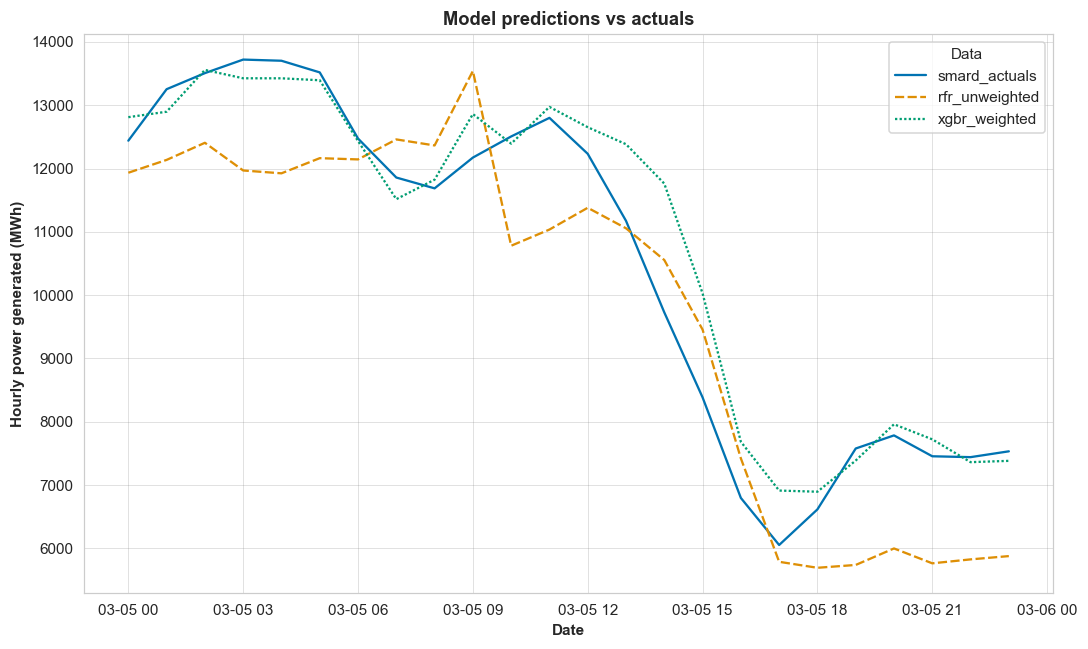

In [326]:
plot_actuals_vs_preds(df_preds_vs_actuals, '2023-03-05', '2023-03-05')

#### Plotting several days

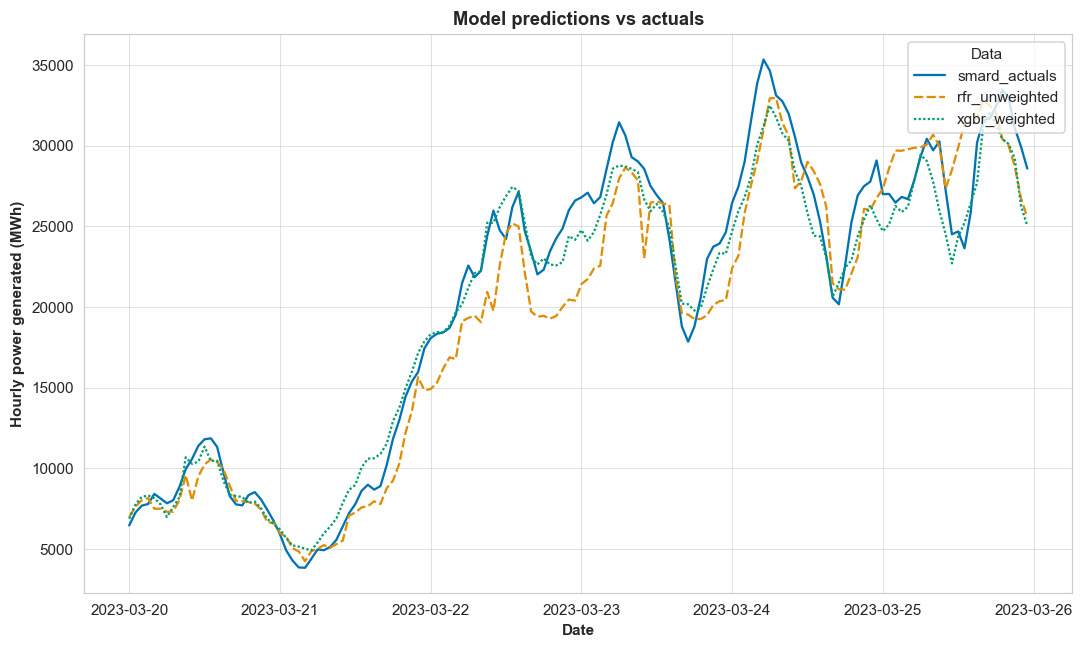

In [327]:
plot_actuals_vs_preds(df_preds_vs_actuals, '2023-03-20', '2023-03-25')

#### Plotting one month

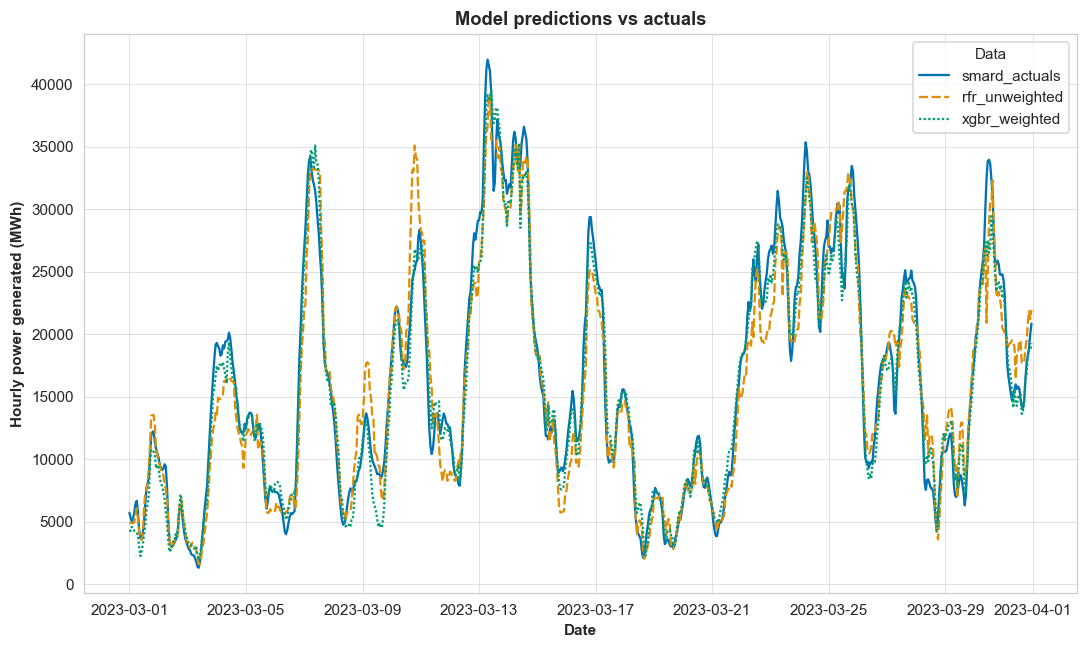

In [328]:
plot_actuals_vs_preds(df_preds_vs_actuals, '2023-03-01', '2023-03-31')